<a href="https://colab.research.google.com/github/machiwao/CCADMACL_EXERCISES_COM222ML/blob/main/exercise6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 6

Netflix is the world's largest online streaming service provider, with over 220 million subscribers. It is crucial that they effectively cluster the shows that are hosted on their platform in order to enhance the user experience, thereby preventing subscribers from ending their subscription.

We will be able to understand the shows that are similar to and different from one another by creating clusters, which may be leveraged to offer the consumers personalized show suggestions depending on their preferences.

## Instructions

1. Your task is to group the Netflix shows into certain clusters such that the shows within a cluster are similar to each other and the shows in different clusters are dissimilar to each other. Use Principal Component Analysis and any Clustering Algorithm.

2. After creating the clusters, profile each cluster that you have created.

In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
import re
import string
string.punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as shc

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [91]:
df = pd.read_csv("https://github.com/robitussin/CCADMACL_EXERCISES/blob/353cd84703a9e313ee7ecf37fb97a067aa81ddbc/netflix.csv?raw=true")

In [92]:
df['cast'].unique()

array(['João Miguel, Bianca Comparato, Michel Gomes, Rodolfo Valente, Vaneza Oliveira, Rafael Lozano, Viviane Porto, Mel Fronckowiak, Sergio Mamberti, Zezé Motta, Celso Frateschi',
       'Demián Bichir, Héctor Bonilla, Oscar Serrano, Azalia Ortiz, Octavio Michel, Carmen Beato',
       'Tedd Chan, Stella Chung, Henley Hii, Lawrence Koh, Tommy Kuan, Josh Lai, Mark Lee, Susan Leong, Benjamin Lim',
       ...,
       'Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanana, Manish Chaudhary, Meghna Malik, Malkeet Rauni, Anita Shabdish, Chittaranjan Tripathy',
       'Nasty C', 'Adriano Zumbo, Rachel Khoo'], dtype=object)

In [93]:
# Create 'seasons' column for type = 'TV Show' that covers duration that contains the string 'Season', else 0
df['seasons'] = np.where((df['type'] == 'TV Show') & (df['duration'].str.contains('Season')), df['duration'].str.split(' ').str[0], 0)
df['seasons'] = pd.to_numeric(df['seasons'], errors='coerce')

In [94]:
# Create minutes column for type = 'Movie' that covers duration which contains the string 'Min', else 0
df['minutes'] = np.where((df['type'] == 'Movie') & (df['duration'].str.contains('min')), df['duration'].str.split(' ').str[0], 0)
df['minutes'] = pd.to_numeric(df['minutes'], errors='coerce')

In [99]:
# Split 'listed_in' into genre columns where one columns corresponds to each item in 'listed_in'
genres_dummies = df['listed_in'].str.get_dummies(sep=', ')
genres_dummies = genres_dummies.drop(genres_dummies.columns[0], axis=1)
df = pd.concat([df, genres_dummies], axis=1)

In [102]:
df.shape

(7787, 55)

In [76]:
df['type'].value_counts()

,count
type,
Movie,5377
TV Show,2410


In [100]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,...,0,0,1,0,0,1,0,0,0,0
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,...,0,0,0,0,0,0,0,0,0,0
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,...,0,0,0,0,0,0,0,0,0,0
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,...,0,0,0,0,0,0,0,0,0,0
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [6]:
df.duplicated().sum()

0

In [7]:
df.isna().sum()

,0
show_id,0
type,0
title,0
director,2389
cast,718
country,507
date_added,10
release_year,0
rating,7
duration,0


In [8]:
df[['director','cast','country']] = df[['director','cast','country']].fillna(' ')
df.dropna(axis=0, inplace=True)

In [9]:
df.duplicated().sum()

0

# Feature Engineering

In [10]:
df['textual_data'] = df['description'] + df['listed_in'] + df['rating'] + df['cast'] + df['country'] + df['director']

In [11]:
stop_words = stopwords.words('english')

In [12]:
def preprocess_text(text):
  # Convert to lowercase
  text = text.lower()
  # remove_digits_urls_special_chars
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  text = re.sub(r'[^a-zA-Z]', ' ', text) # Remove non-alphabetic characters
  text = re.sub(r'\b(\w+)\1+\b', r'\1', text)  # Reduce repeated words to root word
  text = re.sub(r'\@\w+|\#', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = text.strip()
  text = re.sub(r'\s+', ' ', text).strip()
  text = re.sub(r'\s+$', '', text)
  text = re.sub(r'\d+', '', text)


  text = ' '.join([word for word in text.split() if word not in stop_words])

  # Lemmatization
  lemmatizer = WordNetLemmatizer()
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

  return text

In [13]:
df['textual_data'] = df['textual_data'].apply(preprocess_text)

In [14]:
tfidf = TfidfVectorizer(stop_words='english', lowercase=False, max_features=10000)
tfidf.fit(df['textual_data'])

dictionary = tfidf.vocabulary_.items()

In [15]:
print(len(dictionary))

10000


In [16]:
vector = tfidf.transform(df['textual_data']).toarray()

print(vector)
print(f'shape of the vector : {vector.shape}')
print(f'datatype : {type(vector)}')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
shape of the vector : (7770, 10000)
datatype : <class 'numpy.ndarray'>


## Reference for Preprocessing: https://github.com/harkpun/Netflix-Movie-and-TV-Shows-Clustering

1. Apply dimensionality reduction using Principal Component Analysis
- Use the necessary number of principal components

In [17]:
# put your answer here
pca = PCA(random_state=42)
pca.fit(vector)

PCA(random_state=42)

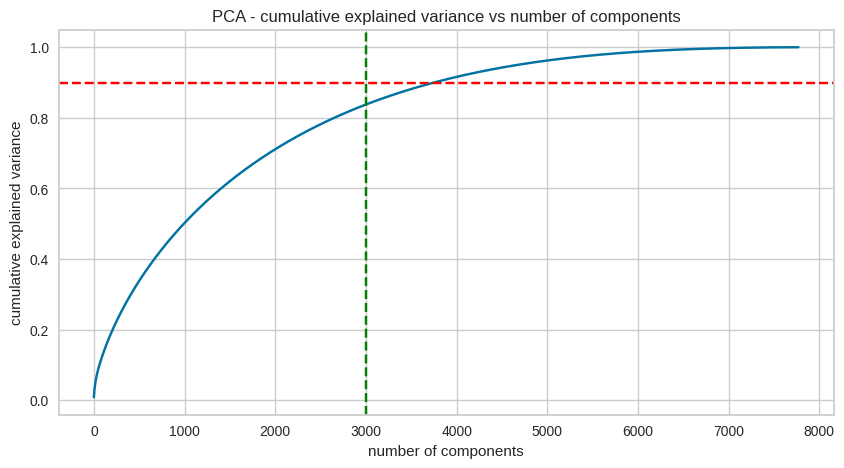

In [19]:
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA - cumulative explained variance vs number of components')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axhline(y= 0.9, color='red', linestyle='--')
plt.axvline(x= 3700, color='green', linestyle='--')
plt.show()

In [25]:
pca_3comps = PCA(n_components = 3, random_state=42)
pca_3comps.fit(vector)

PCA(n_components=3, random_state=42)

2. Create a scree plot for each principal component

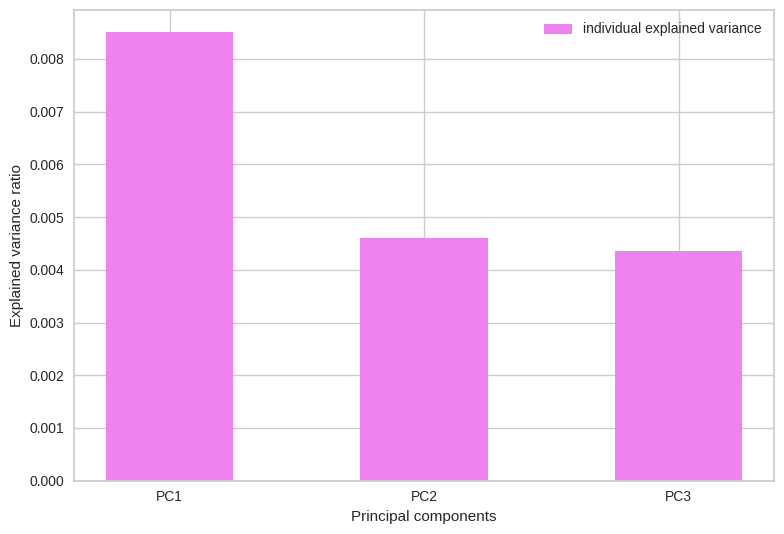

In [26]:
# put your answer here
explained_variance = pca_3comps.explained_variance_ratio_
plt.figure()
principalcomponents = ['PC1', 'PC2', 'PC3']

plt.bar(principalcomponents, explained_variance, width=0.5, label='individual explained variance', color='violet')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

3. Use any clustering algorithm to create clusters

In [ ]:
# put your answer here

4. Profile each cluster that you have generated based on your experiments

In [ ]:
# put your answer here